<a href="https://colab.research.google.com/github/Neo-glitch/computer-vision-masterclass/blob/main/CNN_for_Image_clf(Simpsons_Homer_or_Bart_clf).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 # mount gDrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import numpy as np
import os
import zipfile
from google.colab.patches import cv2_imshow
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # to work effectively with images, no need for using for loops to read image
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# diff from image used for nn clf, images here are split into test and training set
# and each set has each image grouped to diff folder based on the image class
# file must be in this form to work well witb tf cnn.
path = "/content/drive/MyDrive/Computer Vision Masterclass Files/Datasets/homer_bart_2.zip"

zip_object = zipfile.ZipFile(file = path, mode = "r")
zip_object.extractall("./")
zip_object.close()

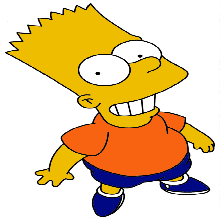

In [ ]:
keras.preprocessing.image.load_img("/content/homer_bart_2/training_set/bart/bart115.bmp", target_size = (220, 220))

### Train and Test set

In [ ]:
# preprocess image and also generate more images using data augmentation
training_generator = ImageDataGenerator(
    rescale = 1./255, # normalize data 
    rotation_range = 7,
    horizontal_flip = True,
    zoom_range = 0.2
)

In [ ]:
train_dataset = training_generator.flow_from_directory("/content/homer_bart_2/training_set",
                                                       target_size = (64, 64),
                                                       batch_size = 8,
                                                       class_mode = "categorical",  # could be binary since we have just two classes
                                                       shuffle =True
                                                       )

Found 215 images belonging to 2 classes.


In [ ]:
train_dataset.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [ ]:
train_dataset.class_indices

{'bart': 0, 'homer': 1}

In [ ]:
# when creating test gen, no need to apply dataAug since we are testing the cnn on this
test_generator = ImageDataGenerator(rescale = 1./255)  

test_dataset = test_generator.flow_from_directory("/content/homer_bart_2/test_set",
                                                       target_size = (64, 64),
                                                       batch_size = 1,              # batch size for test should be 1
                                                       class_mode = "categorical",  # could be binary since we have just two classes
                                                       shuffle = False              # needed for test, so we can compare with associated output(test_data)
                                                       )

Found 54 images belonging to 2 classes.


#### Build and Train the CNN

In [ ]:
network = Sequential([
        # gen 32 feature maps
        Conv2D(filters = 32, kernel_size=(3,3), activation ="relu", padding = "same", input_shape = (64, 64, 3)),
        MaxPool2D(pool_size = (2,2)),

        Conv2D(filters = 32, kernel_size=(3,3), activation ="relu", padding = "valid"),
        MaxPool2D(pool_size = (2,2)),

        Conv2D(filters = 32, kernel_size=(3,3), activation ="relu", padding = "valid"),
        MaxPool2D(pool_size = (2,2)),

        Flatten(),

        # number of neurons in hidden layers = (no_of_inputs_from_flattenLayer + no_outputs) / 2
        # (1152 + 2) / 2 = 577.0

        Dense(units = 577, activation = "relu"),
        Dense(units = 577, activation = "relu"),
        Dense(units = 2, activation = "softmax"),  # since categorical
])

network.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 30, 30, 32)        9248      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 13, 13, 32)        9248      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 6, 6, 32)        

In [ ]:
network.compile(optimizer ="Adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [ ]:
history = network.fit(train_dataset, epochs = 40, validation_data = test_dataset)

Epoch 1/40
27/27 [==============================] - 2s 40ms/step - loss: 0.7225 - accuracy: 0.5767 - val_loss: 0.6748 - val_accuracy: 0.5185
Epoch 2/40
27/27 [==============================] - 1s 26ms/step - loss: 0.6461 - accuracy: 0.6000 - val_loss: 0.6836 - val_accuracy: 0.5370
Epoch 3/40
27/27 [==============================] - 1s 25ms/step - loss: 0.5225 - accuracy: 0.7442 - val_loss: 0.8331 - val_accuracy: 0.6667
Epoch 4/40
27/27 [==============================] - 1s 25ms/step - loss: 0.4719 - accuracy: 0.7674 - val_loss: 0.2811 - val_accuracy: 0.9074
Epoch 5/40
27/27 [==============================] - 1s 26ms/step - loss: 0.3669 - accuracy: 0.8093 - val_loss: 0.4788 - val_accuracy: 0.7963
Epoch 6/40
27/27 [==============================] - 1s 26ms/step - loss: 0.3637 - accuracy: 0.8186 - val_loss: 0.5860 - val_accuracy: 0.7407
Epoch 7/40
27/27 [==============================] - 1s 25ms/step - loss: 0.3167 - accuracy: 0.8558 - val_loss: 0.3309 - val_accuracy: 0.9074
Epoch 8/40
27

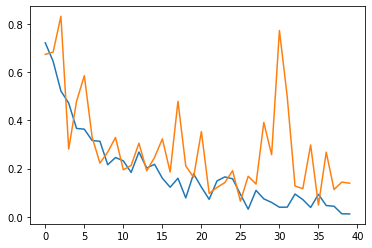

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.show();

### Model evaluation

In [ ]:
test_dataset.class_indices

{'bart': 0, 'homer': 1}

In [ ]:
predictions = np.argmax(network.predict(test_dataset), axis = 1)

predictions

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
test_dataset.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

Model accuracy: 0.9444444444444444
Model accuracy: 0.9259259259259259
Model accuracy: 0.9615384615384616
Model accuracy: 0.9433962264150944


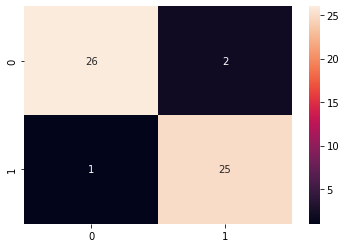

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, \
                            confusion_matrix, classification_report

y_test = test_dataset.classes

print(f"Model accuracy: {accuracy_score(y_test, predictions)}")
print(f"Model precision: {precision_score(y_test, predictions)}")
print(f"Model recall: {recall_score(y_test, predictions)}")
print(f"Model f1_score: {f1_score(y_test, predictions)}")


sns.heatmap(confusion_matrix(y_test, predictions), annot =True)


In [ ]:
print(classification_report(y_test, predictions, target_names = ["bart", "homer"]))

              precision    recall  f1-score   support

        bart       0.96      0.93      0.95        28
       homer       0.93      0.96      0.94        26

    accuracy                           0.94        54
   macro avg       0.94      0.95      0.94        54
weighted avg       0.95      0.94      0.94        54



### Saving and Loading Model

In [ ]:
model_json = network.to_json()
with open("model.json", "w") as json_file:
  json_file.write(model_json)


In [ ]:
from keras.models import save_model
model_saved = save_model(network, "/content/weights.hdf5")

In [ ]:
# Load the model
with open("model.json", "r") as json_file:
  json_saved_model = json_file.read()

json_saved_model


network_loaded = keras.models.model_from_json(json_saved_model)
network_loaded.load_weights("weights.hdf5")
network_loaded.compile(loss = "categorical_crossentropy", optimizer = "Adam", metrics = ["accuracy"])

network.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 30, 30, 32)        9248      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 13, 13, 32)        9248      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 6, 6, 32)        

#### clf a single image

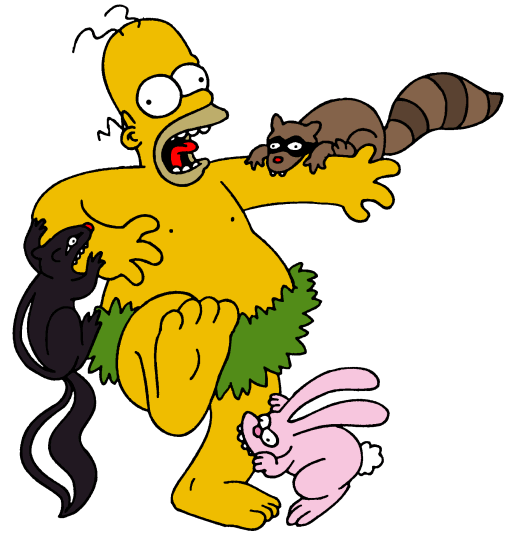

In [ ]:
image = cv2.imread("/content/homer_bart_2/test_set/homer/homer15.bmp")
cv2_imshow(image)

In [ ]:
image.shape

(536, 514, 3)

In [ ]:
# reshape image to input shape of CNN
image = cv2.resize(image, (64, 64))

print(image.shape)

print(f"image max number an min are: {image.max()}, {image.min()}")

(64, 64, 3)
image max number an min are: 255, 0


In [ ]:
# scale the image
image = image / 255.
print(f"image max number an min are: {image.max()}, {image.min()}")

image max number an min are: 1.0, 0.0


In [ ]:
# add new dim to denote batch size for image training
image = image.reshape(-1, 64, 64, 3)
image.shape

(1, 64, 64, 3)

In [ ]:
result = np.argmax(network_loaded.predict(image))

if(result == 0):
  print("bart")
else:
  print("Homer")

Homer
